In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# GPUが利用可能か確認し、利用可能な場合は使用する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# データの前処理定義
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
# CIFAR-10データセットのダウンロードとロード
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:11<00:00, 14349937.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# ResNetの定義とGPUへの移動
import torchvision.models as models
net = models.resnet18(pretrained=False)
net.fc = nn.Linear(net.fc.in_features, 10)  # 出力層の変更（CIFAR-10は10クラスなので）
net.to(device)  # モデルをGPUに移動

# 損失関数とオプティマイザの定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
# 学習の関数
def train_model(net, trainloader, criterion, optimizer, num_epochs=10):
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch+1}/{num_epochs}")
        for i, data in progress_bar:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # データをGPUに移動
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'loss': running_loss / (i+1)})
        
        losses.append(running_loss / len(trainloader))
        print(f"[Epoch {epoch+1}] loss: {running_loss / len(trainloader)}")
    
    print('Finished Training')
    return losses
# モデルの評価の関数
def evaluate_model(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # データをGPUに移動
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

# 学習曲線のプロットの関数
def plot_training_curve(losses):
    plt.figure()
    plt.plot(np.arange(len(losses)), losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

Epoch 1/10: 100%|██████████████████████████████████████████████████████| 12500/12500 [02:15<00:00, 92.45it/s, loss=1.93]


[Epoch 1] loss: 1.9335511228632927


Epoch 2/10: 100%|███████████████████████████████████████████████████████| 12500/12500 [02:12<00:00, 94.48it/s, loss=1.5]


[Epoch 2] loss: 1.4994111076271535


Epoch 3/10: 100%|██████████████████████████████████████████████████████| 12500/12500 [02:15<00:00, 92.04it/s, loss=1.26]


[Epoch 3] loss: 1.2639911446204781


Epoch 4/10: 100%|██████████████████████████████████████████████████████| 12500/12500 [02:17<00:00, 91.23it/s, loss=1.12]


[Epoch 4] loss: 1.117693957324177


Epoch 5/10: 100%|██████████████████████████████████████████████████████| 12500/12500 [02:19<00:00, 89.66it/s, loss=1.01]


[Epoch 5] loss: 1.0065367544017731


Epoch 6/10: 100%|█████████████████████████████████████████████████████| 12500/12500 [02:21<00:00, 88.39it/s, loss=0.906]


[Epoch 6] loss: 0.9056611400946603


Epoch 7/10: 100%|██████████████████████████████████████████████████████| 12500/12500 [02:25<00:00, 85.96it/s, loss=0.83]


[Epoch 7] loss: 0.830431589493379


Epoch 8/10: 100%|█████████████████████████████████████████████████████| 12500/12500 [02:28<00:00, 84.43it/s, loss=0.763]


[Epoch 8] loss: 0.7628950262574479


Epoch 9/10: 100%|█████████████████████████████████████████████████████| 12500/12500 [02:35<00:00, 80.48it/s, loss=0.697]


[Epoch 9] loss: 0.6967414471823722


Epoch 10/10: 100%|█████████████████████████████████████████████████████| 12500/12500 [02:26<00:00, 85.31it/s, loss=0.64]


[Epoch 10] loss: 0.6401837576937676
Finished Training


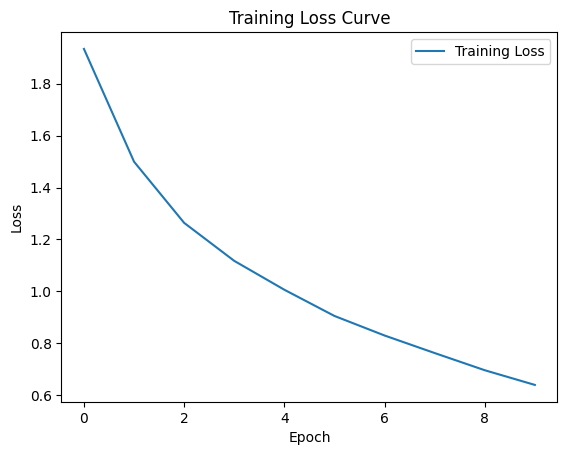

In [6]:
# 実際の学習
train_losses = train_model(net, trainloader, criterion, optimizer, num_epochs=10)
plot_training_curve(train_losses)

In [7]:
# モデルの評価
evaluate_model(net, testloader)

Accuracy of the network on the 10000 test images: 69.84%
